## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_camcal_parameters():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        print(fname)
        img = cv2.imread(fname)
        #print(img)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        print(ret)
        #plt.imshow(img)
        #plt.show()
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)

            cv2.waitKey(500)

    cv2.destroyAllWindows()
    return objpoints,imgpoints

In [6]:
import matplotlib.image as mpimg

def undistort_img(img,objpoints,imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #img=img[:,:,-1]
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #ax1.imshow(img)
    #ax1.set_title('Original Image', fontsize=30)
    #ax2.imshow(dst)
    #ax2.set_title('Undistorted Image', fontsize=30)
    #plt.show()
    return dst


## Apply a distortion correction to raw images.

In [7]:
objpoints, imgpoints=get_camcal_parameters()


camera_cal/calibration1.jpg
False
camera_cal/calibration10.jpg
True
camera_cal/calibration11.jpg
True
camera_cal/calibration12.jpg
True
camera_cal/calibration13.jpg
True
camera_cal/calibration14.jpg
True
camera_cal/calibration15.jpg
True
camera_cal/calibration16.jpg
True
camera_cal/calibration17.jpg
True
camera_cal/calibration18.jpg
True
camera_cal/calibration19.jpg
True
camera_cal/calibration2.jpg
True
camera_cal/calibration20.jpg
True
camera_cal/calibration3.jpg
True
camera_cal/calibration4.jpg
False
camera_cal/calibration5.jpg
False
camera_cal/calibration6.jpg
True
camera_cal/calibration7.jpg
True
camera_cal/calibration8.jpg
True
camera_cal/calibration9.jpg
True


In [8]:
img = mpimg.imread('camera_cal/calibration1.jpg')
undist=undistort_img(img,objpoints,imgpoints)


In [9]:
distorted_images = glob.glob('test_images/*.jpg')
for filename in distorted_images:
    print(filename)
    img = mpimg.imread(filename)
    undist=undistort_img(img,objpoints,imgpoints)

test_images/straight_lines1.jpg
test_images/straight_lines2.jpg
test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg


## Use color transforms, gradients, etc., to create a thresholded binary image.

In [10]:

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    #abs_sobelx = np.absolute(gradmag)
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output
    
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def combine_threshold(img,ksize = 3):
     # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(0, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(0, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def color_threshold(img,thresh_min = 20,thresh_max = 100):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    plt.imshow(sxbinary, cmap='gray')

    
def pipeline1(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    print(sxbinary.shape)
    print(s_binary.shape)

    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    print(color_binary.shape)
    
    return color_binary

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    

test_images/straight_lines1.jpg


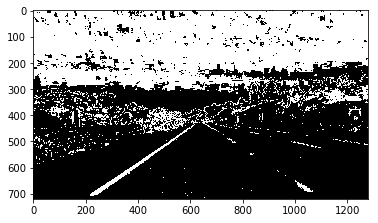

test_images/straight_lines2.jpg


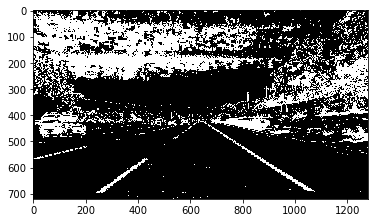

test_images/test1.jpg


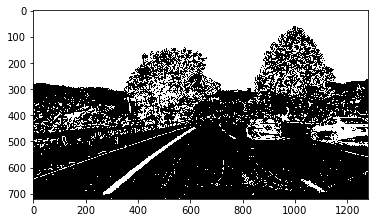

test_images/test2.jpg


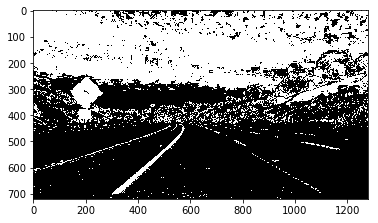

test_images/test3.jpg


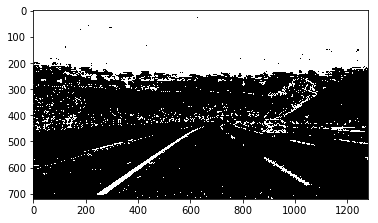

test_images/test4.jpg


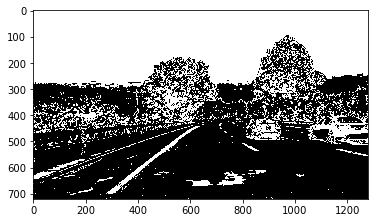

test_images/test5.jpg


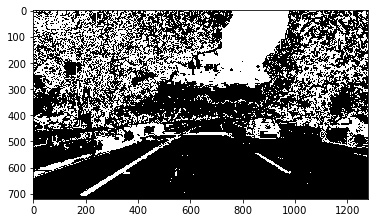

test_images/test6.jpg


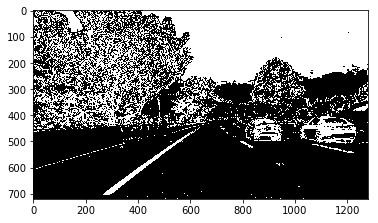

In [11]:
distorted_images = glob.glob('test_images/*.jpg')
for filename in distorted_images:
    print(filename)

    img = mpimg.imread(filename)
    undist=undistort_img(img,objpoints,imgpoints)
    bin_img=pipeline(undist,(100,255))
    plt.imshow(bin_img,cmap='gray')
    plt.show()

## Apply a perspective transform to rectify binary image ("birds-eye view"). 

In [21]:

straight_line1_img=mpimg.imread('test_images/straight_lines1.jpg')                 

print(straight_line1_img.shape)

def convert_bird_view(img):
    src= np.float32([[260,684],[609,441],[667,441],[1035,677]])
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[303, 660],
                      [562, 472],
                      [725, 472],
                      [1003, 660]])

    offset=100
    dst = np.float32([[offset, img_size[1]-offset],
                     [offset, offset],
                     [img_size[0] - offset, offset],
                     [img_size[0] - offset, img_size[1]-offset ]])

    M = cv2.getPerspectiveTransform(src, dst)
    MInv = cv2.getPerspectiveTransform(dst, src)
    return M,MInv

def perspective_transform(img,M,MInv):
    img_size=(img.shape[1],img.shape[0])
    warped_img = cv2.warpPerspective(img, M, img_size)
    warped_img_inv = cv2.warpPerspective(warped_img, MInv, img_size)
    return warped_img,warped_img_inv





(720, 1280, 3)


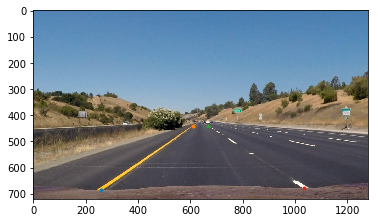

In [22]:
plt.imshow(straight_line1_img)
#plt.imshow(img)
plt.plot(260,684,'.')
plt.plot(609,441,'.')
plt.plot(667,441,'.')
plt.plot(1035,677,'.')
plt.show()


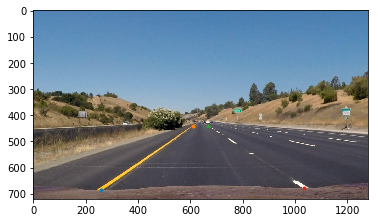

In [23]:

plt.imshow(straight_line1_img)
#plt.imshow(img)
plt.plot(260,684,'.')
plt.plot(609,441,'.')
plt.plot(667,441,'.')
plt.plot(1035,677,'.')
plt.show()


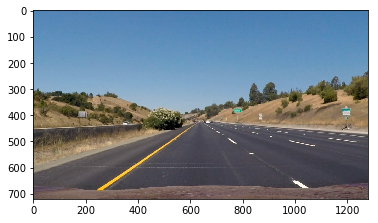

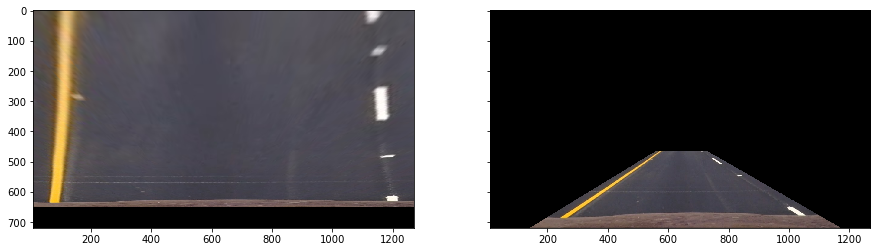

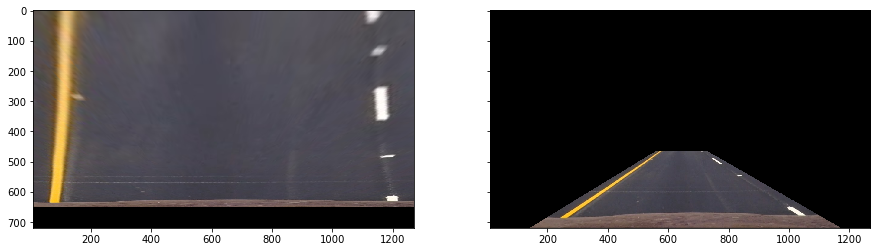

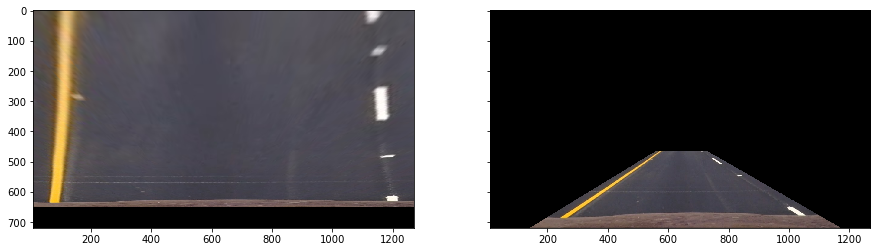

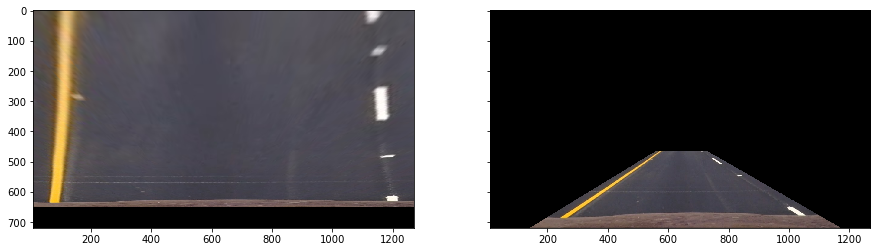

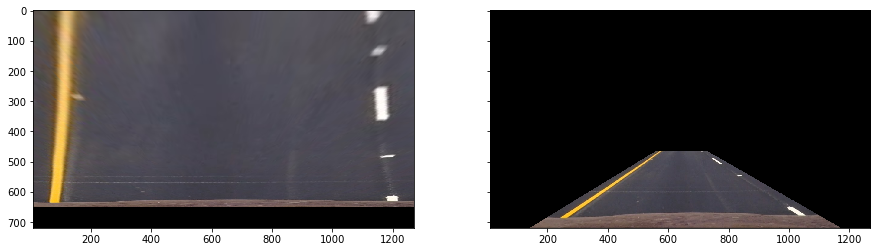

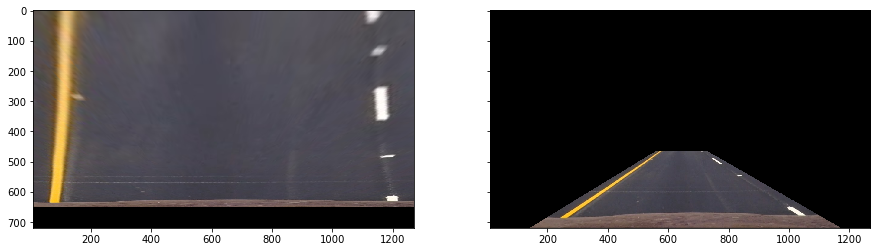

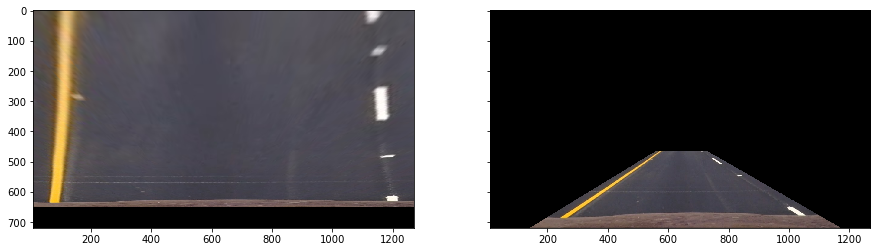

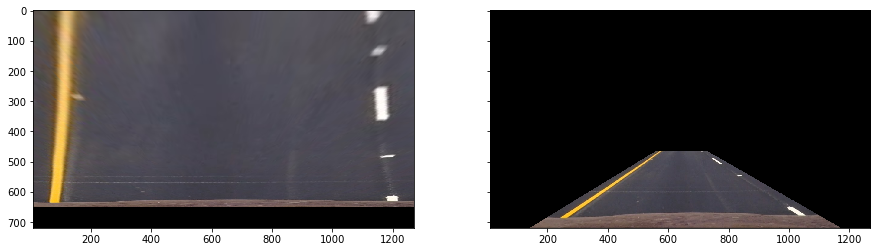

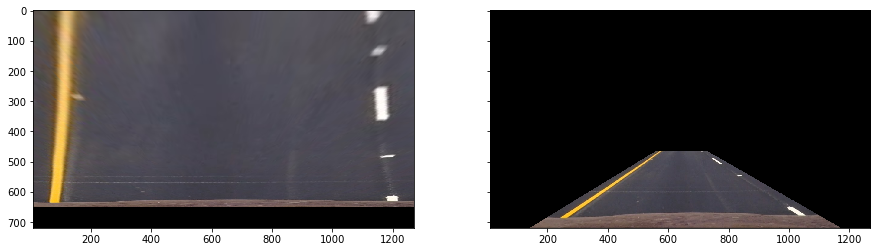

In [24]:
M,MInv=convert_bird_view(straight_line1_img)

straight_lines_1_warp,straight_lines_1_warp_inv = perspective_transform(straight_line1_img,M,MInv)

plt.imshow(straight_line1_img)
plt.show()

f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches([15., 4.])
ax1.imshow(straight_lines_1_warp)
ax2.imshow(straight_lines_1_warp_inv)


test_images = glob.glob('test_images/*.jpg')

for filenmae in test_images:
    img=mpimg.imread(filenmae)    
    img_warp,img_warp_inv = perspective_transform(straight_line1_img,M,MInv)
    f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
    f.set_size_inches([15., 4.])
    ax1.imshow(img_warp)
    ax2.imshow(img_warp_inv)
    


#  Detect lane pixels and fit to find the lane boundary.

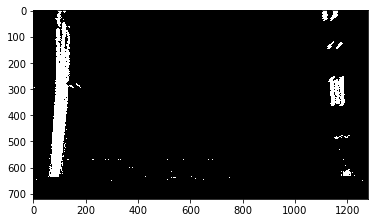

In [25]:

binary_image=pipeline(straight_lines_1_warp)
plt.imshow(binary_image,cmap='gray')
plt.show()

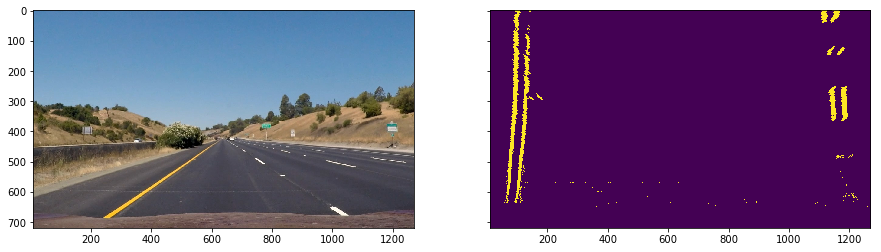

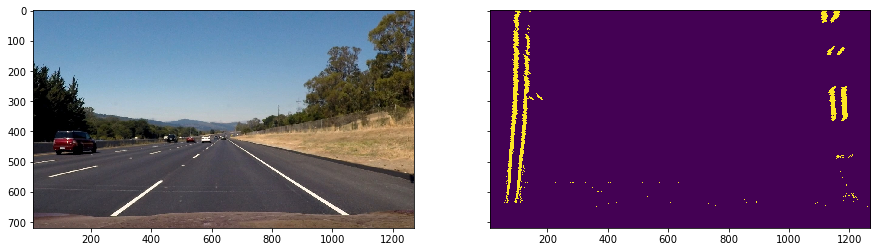

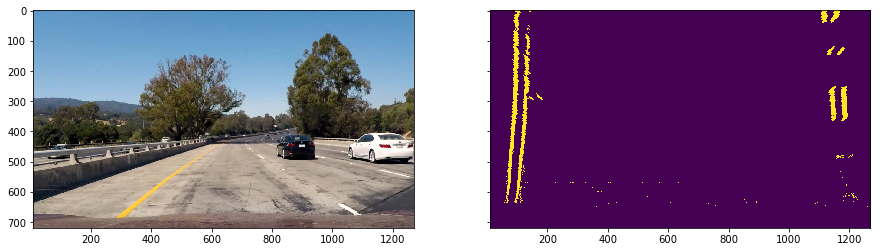

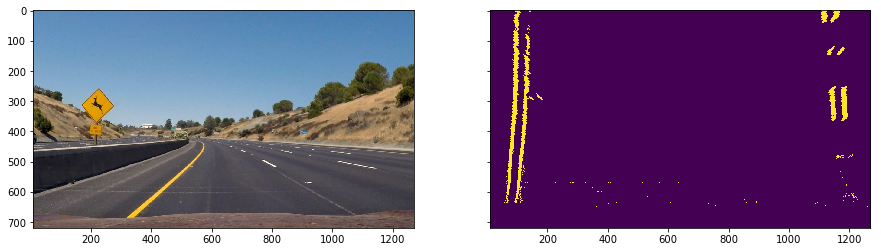

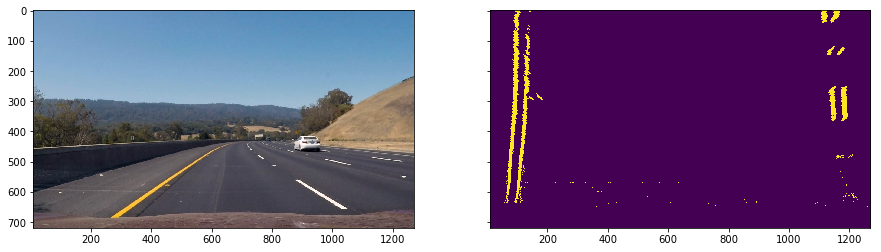

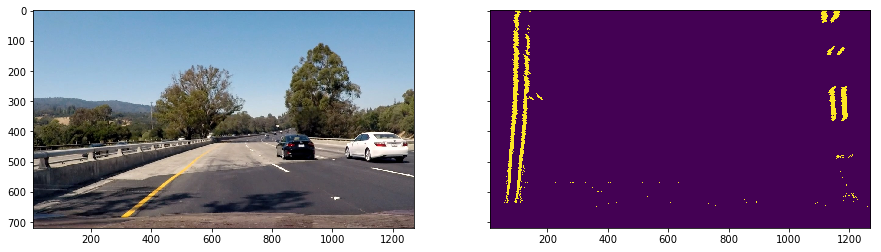

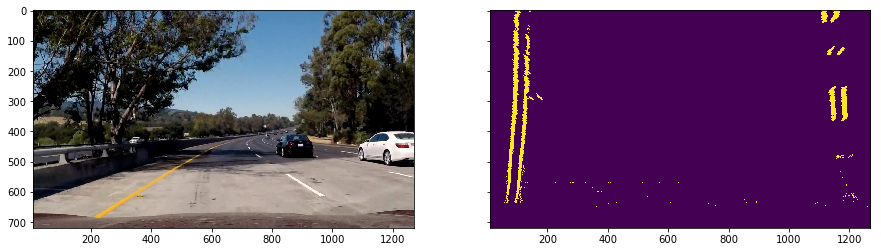

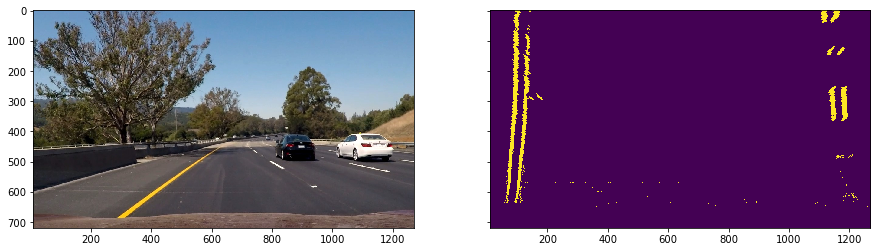

In [26]:
for filenmae in test_images:
    img=mpimg.imread(filenmae)    
    img_warp,img_warp_inv = perspective_transform(straight_line1_img,M,MInv)
    f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
    f.set_size_inches([15., 4.])
    ax1.imshow(img)
    binary_image=pipeline(img_warp,s_thresh=(255,0))

    ax2.imshow(binary_image)
    plt.show()

## Find starting point through histogram

In [37]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output


def find_window_centroids(warped, window_width, window_height, margin):
    window_centroids = []
    window = np.ones(window_width)
    
     # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def find_lines(warped,window_width, window_height, margin):
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows     
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[ (l_mask == 1)  ] = 255
            r_points[ (r_mask == 1)  ] = 255
            #l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            #r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.75, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output,l_points,r_points,window_centroids
    

In [70]:
def find_line2(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit

In [71]:
binary_warped=binary_image
binary_warped.shape[0]/2
#binary_warped[binary_warped.shape[0]/2:,:]
#np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
left_fit,right_fit=find_line2(binary_image)

In [99]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


In [100]:
left_fitx

array([ 103.11229667,  103.18415256,  103.25567757,  103.32687167,
        103.39773488,  103.4682672 ,  103.53846861,  103.60833914,
        103.67787876,  103.74708749,  103.81596533,  103.88451226,
        103.95272831,  104.02061345,  104.0881677 ,  104.15539106,
        104.22228351,  104.28884507,  104.35507574,  104.42097551,
        104.48654438,  104.55178236,  104.61668944,  104.68126563,
        104.74551092,  104.80942531,  104.87300881,  104.93626141,
        104.99918311,  105.06177392,  105.12403384,  105.18596285,
        105.24756097,  105.3088282 ,  105.36976453,  105.43036996,
        105.4906445 ,  105.55058814,  105.61020088,  105.66948273,
        105.72843369,  105.78705374,  105.8453429 ,  105.90330117,
        105.96092854,  106.01822501,  106.07519059,  106.13182527,
        106.18812905,  106.24410194,  106.29974393,  106.35505503,
        106.41003523,  106.46468453,  106.51900294,  106.57299045,
        106.62664707,  106.67997279,  106.73296761,  106.78563

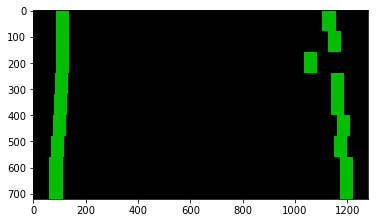

In [38]:
warped=binary_image
output,l_points,r_points,window_centroids = find_lines(binary_image,window_width, window_height, margin)
plt.imshow(output)



In [55]:
lys=[]
lxs=[]

for level in range(0,len(window_centroids)):
    ly=int(binary_image.shape[0]-(level+1)*window_height)
    lx=int(window_centroids[level][0])
    lys.append(ly)
    lxs.append(lx)

rys=[]
rxs=[]

for level in range(0,len(window_centroids)):
    ry=int(binary_image.shape[0]-(level+1)*window_height)
    rx=int(window_centroids[level][1])
    rys.append(ry)
    rxs.append(rx)

In [56]:
lys

[640, 560, 480, 400, 320, 240, 160, 80, 0]

In [57]:
lxs

[88, 88, 94, 100, 106, 110, 112, 113, 112]

##### 

In [58]:

res_left = np.zeros_like(l_points)
res_left[(l_points > 0) & (binary_image > 0)] = 255

res_right = np.zeros_like(r_points)
res_right[(r_points > 0) & (binary_image > 0)] = 255


straight_lines_1_warp.shape


(720, 1280, 3)

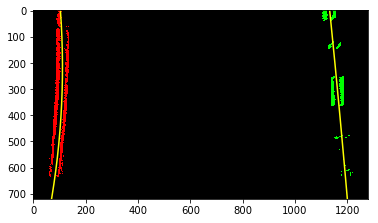

In [102]:
lanes = np.zeros_like(straight_lines_1_warp)
lanes[:,:,0] = res_left
lanes[:,:,1] = res_right

plt.imshow(lanes)
#plt.plot(lxs,lys)
#plt.plot(rxs,rys)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

# Find polyfit

In [31]:
def fit_poly(lane_points, coef=None):
    coef = coef or []
    y, x = np.nonzero(lane_points)
    a, b, c = np.polyfit(y, x[::-1], 2)
    if len(coef) != 0:
        diff = 0.333 * (abs(a - coef[0][0]) / max(a, coef[0][0]) \
                        + abs(b - coef[0][1]) / max(b, coef[0][1]) \
                        + abs(c - coef[0][2]) / max(c, coef[0][2]))
        if diff > 0.25:
            print(diff)
            a, b, c = coef[0]
    
    coef.insert(0, [a,b,c])
    coef_mean = np.mean(coef, 0)
    return np.array([coef_mean[0]*y*y + coef_mean[1]*y + coef_mean[2] for y in range(0, lane_points.shape[0])])


y_left, x_left = np.nonzero(res_left)
x_pred_left = fit_poly(res_left)
# fit_left = np.polyfit(y_left, x_left[::-1], 2)
# x_pred_left = [fit_left[0]*y*y + fit_left[1]*y + fit_left[2]
#                for y in range(0, res_left.shape[0])]

y_right, x_right = np.nonzero(res_right)
x_pred_right = fit_poly(res_right)
# fit_right = np.polyfit(y_right, x_right[::-1], 2)
# x_pred_right = [fit_right[0]*y*y + fit_right[1]*y + fit_right[2]
#                 for y in range(0, res_right.shape[0])]

(0, 1280)

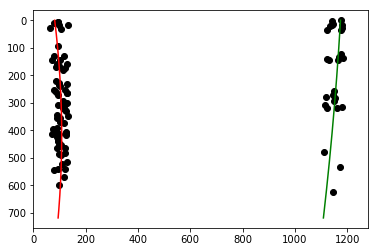

In [36]:
sample_left = np.random.choice(len(y_left), int(0.005*len(y_left)), False)
sample_right = np.random.choice(len(y_right), int(0.005*len(y_right)), False)

plt.plot(x_left[sample_left][::-1], y_left[sample_left], 'ko',
         x_pred_left, range(0, res_left.shape[0]), 'r',
         x_right[sample_right][::-1], y_right[sample_right], 'ko',
         x_pred_right, range(0, res_right.shape[0]), 'g')

plt.gca().invert_yaxis()
plt.xlim([0, res_left.shape[1]])

In [105]:
def fill_between_lanes(warped):
    ploty = np.linspace(0, warped.shape[0]-1, binary_warped.shape[0] )
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])

    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])


    pts = np.hstack((pts_left, pts_right))


    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInv, (straight_line1_img.shape[1], straight_line1_img.shape[0]))
    newwarp[:newwarp.shape[0]//4,:,:] = 0
    result = cv2.addWeighted(straight_line1_img, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    return result


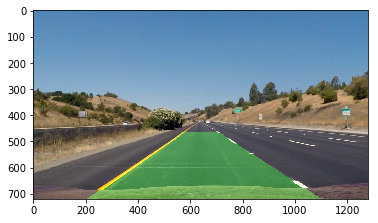

In [106]:
fill_between_lanes(warped)

In [98]:
window_width = 40 
window_height = 250 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching

poly_left = []
poly_right = []

def get_curverad(coef, y):
    return ((1 + (2*coef[0]*y + coef[1])**2)**1.5) / np.abs(2*coef[0])


def fit_poly(lane_points, coef=None):
    coef = coef if coef is not None else []
    y, x = np.nonzero(lane_points)
    a, b, c = np.polyfit(y, x[::-1], 2)
    if len(coef) != 0:
        coef_mean = np.mean(coef, 0)
        mean_rad = get_curverad(coef_mean, np.max(y))
        curr_rad = get_curverad([a,b,c], np.max(y))
        if (curr_rad - mean_rad) / max(mean_rad, curr_rad) > 0.25:
            if len(set(coef)) > 0.5 * len(coef):
                a, b, c = coef[0]
    
    coef.insert(0, (a, b, c))
    coef_mean = np.mean(coef, 0)
    return np.array([coef_mean[0]*y*y + coef_mean[1]*y + coef_mean[2]
                     for y in range(0, lane_points.shape[0])])


def process_image(img):
    global poly_left
    global poly_right
    img_size = (img.shape[1], img.shape[0])
    # Undistort image
    undistorted = undistort_img(img,objpoints,imgpoints)
    # Warp image to bird eye view
    warped = cv2.warpPerspective(undistorted, M, (img_size[0] , img_size[1]))
    # Convert to HSV color space
    hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
    
    blur = cv2.blur(hls, (3,3))
    
    # Preprocess with sobel filter
    
    sobelx_l = cv2.Sobel(blur[:,:,1], cv2.CV_64F, 1, 0, ksize=3)
    sobelx_l = np.abs(sobelx_l) / np.max(np.abs(sobelx_l))
    
    sobely_l = cv2.Sobel(blur[:,:,1], cv2.CV_64F, 0, 1, ksize=5)
    sobely_l = np.abs(sobely_l) / np.max(np.abs(sobely_l))

    sobelx_s = cv2.Sobel(blur[:,:,2], cv2.CV_64F, 1, 0, ksize=3)
    sobelx_s = np.abs(sobelx_s) / np.max(np.abs(sobelx_s))
    
    sobely_s = cv2.Sobel(blur[:,:,2], cv2.CV_64F, 0, 1, ksize=5)
    sobely_s = np.abs(sobely_s) / np.max(np.abs(sobely_s))
    
    sobel_l = np.sqrt(sobelx_l*sobelx_l + sobely_l*sobely_l)
    sobel_s = np.sqrt(sobelx_s*sobelx_s + sobely_s*sobely_s)
    
    sobel = 255. * (0.75 * sobel_s + 0.25 * sobel_l)
    # sobel[-sobel.shape[0]//5:,:] = 0
    
    # Extract centroid points
    window_centroids = find_window_centroids(sobel, window_width, window_height, margin)
    
    l_points = np.zeros_like(sobel)
    r_points = np.zeros_like(sobel)

    # Go through each level and draw the windows     
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,sobel,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,sobel,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        
    res_left = np.zeros_like(sobel)
    res_left[(l_points != 0) & (sobel > 5)] = 255

    res_right = np.zeros_like(sobel)
    res_right[(r_points != 0) & (sobel > 5)] = 255
    
    x_fit_left = fit_poly(res_left, poly_left)
    x_fit_right = fit_poly(res_right, poly_right)
    
    if len(poly_left) > 25:
        poly_left.pop()
        poly_right.pop()
    
    # Backproject to original image
    ploty = list(range(0, warped.shape[0]))

    pts_left = np.array([np.transpose(np.vstack([x_fit_left, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([x_fit_right, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    warp_zero = np.zeros_like(sobelx_l).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInv, img_size)
    
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result, warped, hls, sobel, res_left, res_right

In [ ]:
result, warped, hls, sobel, res_left, res_right = process_image(cv2.imread('./test_images/test2.jpg'))
f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, sharey=True)
f.set_size_inches([24., 10.])
ax1.imshow(result)
ax2.imshow(warped)
ax3.imshow(sobel, cmap='gray')
ax4.imshow(res_left + res_right, cmap='gray')

In [ ]:
import imageio
imageio.plugins.ffmpeg.download()


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'processed_video_project.mp4'

clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(lambda img: process_image(img)[0])
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## And so on and so forth...